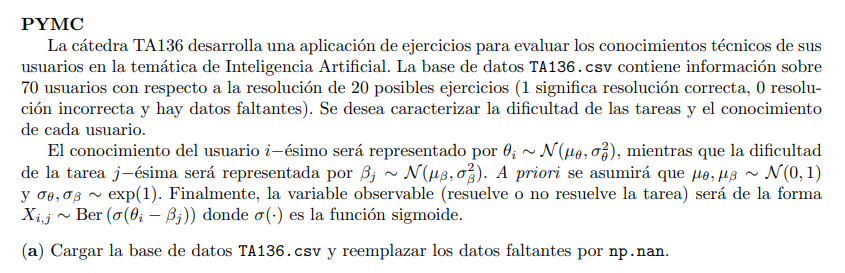

##**Fundamentos**
Se construye el modelo bayesiano y se ajusta a los datos usando algoritmos de cadenas de Markov.


Se quiere modelar el conocimiento de los alumnos como una normal con una media $\mu_{\theta}$ y una varianza $\sigma^2_{\theta}$.


La dificultad de la tarea j en el curso va a estar modelada tambien como $β_j$ tambien con los mismos parametros pero funcion de Beta. Como es un modelo Bayesiano, se propone una distribucion a priori, se multiplica por la funcion de verosimlitud, que dice como se relacionan los datos con el modelo (por ejemplo decir que siguen una distribucion normal al rededor de la media), se sabe que la multiplicacion de ambos es proporcional a la posteriori. Es el belief actualizado despues de que la a priori se expuso a los datos.


PyMC lo que hace es muestrear en lugar de calcular la distribucion a posteriori matematicamente (ya que habria que hacer integrales sobre los parametros y muchas veces no tienen forma cerrada).

##**Importacion de datos y librerias**

In [11]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

#URL del git de matias
url = "https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/main/data/TA136.csv"

#curl para bajar el archivo
!curl -L $url -o TA136.csv

# Cargo la base, los faltantes se leen como NaN
df = pd.read_csv("TA136.csv", na_values=["", "NA", "NaN"])
#Solo para verlo yo.
df


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6109  100  6109    0     0  38179      0 --:--:-- --:--:-- --:--:-- 38421


,Unnamed: 0,item 0,item 1,item 2,item 3,item 4,item 5,item 6,item 7,item 8,...,item 10,item 11,item 12,item 13,item 14,item 15,item 16,item 17,item 18,item 19
0,usuario 0,1.0,0.0,1.0,NaN,0.0,0.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,usuario 1,1.0,0.0,0.0,NaN,0.0,NaN,1.0,1.0,0.0,...,0.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0
2,usuario 2,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
3,usuario 3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,usuario 4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,usuario 65,1.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
66,usuario 66,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
67,usuario 67,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,0.0
68,usuario 68,1.0,1.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,...,NaN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN


(b) Construir el modelo bayesiano antes descripto en PyMC.

In [12]:
# df ya cargado en el punto (a)

#Me quedo solo con columnas numéricas (0/1 y NaN)
df_numeric = df.select_dtypes(include=[np.number])

# Convierto a matriz numpy
data = df_numeric.values.astype(float)

n_users, n_items = data.shape

# Máscara de observaciones que estan
mask = ~np.isnan(data) #Si no es NaN
user_idx, item_idx = np.where(mask) #Guardo los usuarios e items que estan.
observed = data[user_idx, item_idx].astype(int) #uso la mascara como filtro.


In [13]:
with pm.Model() as model:
    # Priors de medias
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=1) #Las medias son ambas normales 0,1
    mu_beta  = pm.Normal("mu_beta",  mu=0, sigma=1)

    # Priors de desvíos
    sigma_theta = pm.Exponential("sigma_theta", 1) #Las varianzas son ambos exponenciales de parametro 1
    sigma_beta  = pm.Exponential("sigma_beta", 1)

    # Latentes: conocimiento y dificultad
    theta = pm.Normal("theta", mu=mu_theta, sigma=sigma_theta, shape=n_users)#La dificultad y que tan buenos son los alumnos son funcion de su respectivo mu y sigma beta/theta
    beta  = pm.Normal("beta",  mu=mu_beta,  sigma=sigma_beta, shape=n_items)#son ambas normales

    # Probabilidad Bernoulli: sigmoide(tita_i - beta_i), probabilidad de aprobar algo, que tan bueno es el alumno - la dificultad de una tarea
    logits = theta[user_idx] - beta[item_idx]
   # p = pm.math.sigmoid(logits)
    p = pm.Deterministic("p",pm.math.sigmoid(logits))
    #Verosimilitud de la bernoulli para las observaciones
    X_obs = pm.Bernoulli("X_obs", p=p, observed=observed)


(c) Utilizando model_to_graphviz (PyMC), graficar la red bayesiana. ¿C´omo interpreta la red los datos
faltantes?

La red bayesiana solo calcula las distribuciones a posteriori con los datos observados, si para un cierto usuario i veo que le fue muy bien en muchas tareas, la distribucion para el mismo va a ser de una media elevada y una varianza pequenia, una campana angosta. En cambio, si a otro usuario solo tengo dos observaciones, ambas favorables, la campana va a ser muy ancha ya que no se esta seguro acerca de la performance del alumno. Es decir, al no ver un enlace entre usuario y tarea no realizada, el dato no aporta evidencia, resultando en mayor incertidumbre para los parametros del usuario sin sesgar el resultado.

##**Como se interpreta el modelo**
Esto es segun la consigna, las medias se modelan como distribuciones normales $(0,1)$ y las varianzas como exponenciales de parametro 1.


La idea es definir un usuario promedio, con cuanto varia la poblacion, y una tarea promedio, con cuanto varia su dificultad. A nivel general, la idea es comparar que tan bueno es un usuario vs que tan dificil fue la tarea. Despues la sigmoide va a sacar una probabilidad, si la tarea esta al mismo nivel que la habilidad del usuario, no va a haber diferencia, entonces la probabilidad de poder acertar que el usuario i va a poder terminar la tarea j es directamente de un 50%.


Despues, la observable que representa si un usuario resuelve o no la tarea, funcion del conocimiento y de si fue realizada, se modela como una Bernoulli de la sigmoide(probabilidad) de $\theta_i - \beta_i$, fija la probabilidad de que se termine una tarea y se hace la probabilidad binaria de las dos con la Bernoulli.



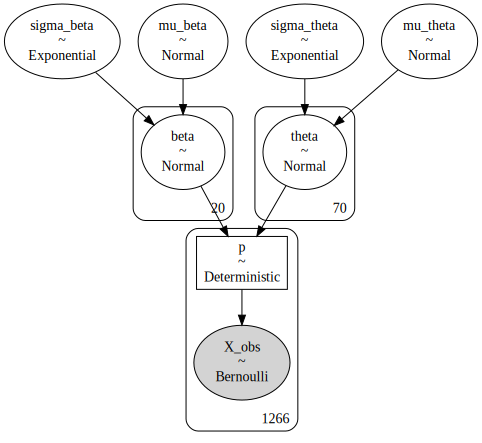

In [14]:
pm.model_to_graphviz(model)

(d) Muestrear 3 cadenas del experimento. Elegir los par´ametros draws, tune y target accept de manera
de alcanazar un ESS (bulk) > 30 y un Rˆ menor o igual que 1.1, en todos los θi y βj . c: La funci´on
summary (arviz) puede ser ´util.

##**Que son esos parametros**
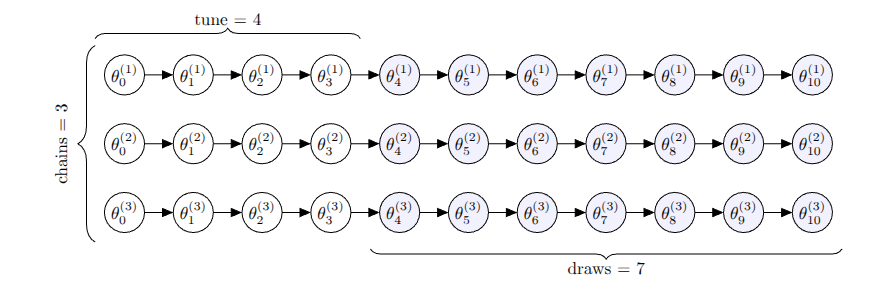

Esto es lo que entendi del apunte:

###**Monte Carlo por Cadenas de Markov (MCMC)**

Como estoy haciendo cadenas de Markov, tengo que asegurarme que llegue al estado estacionario. Digo que la distribucion es estacionaria si su estadistica no varia al propagarse por la cadena.


La idea general es construir una cadena de markov homogenea cuya distribucion estacionaria sea la distribucion a posteriori. Con ciertas condiciones, el teorema de la ergodicidad garantiza que el promedio de los valores generados por la cadena converge a la esperanza.


###**Parametros**
Draws van a ser la cantidad de muestras con las que me voy a quedar una vez en el presunto estado estacionario.


Voy a dejar pasar tune pasos para considerar que estoy en el estacionario y voy a simular tres cadenas independientes (esto es por consigna).


La idea sobre un proceso estacionario (para optimizar en realidad sobre una muestra, no bayesiano, pero el concepto es el mismo)


El ejemplo mas sencillo que se me ocurre: Si un usuario empieza con un prior de media 0 y varianza 1, una muestra generada puede ser un $\mu$ tita de 0.4, luego, cuando se calcula la esperanza cuando se observa un 1, ese promedio ahora pasa a ser 0.7. Luego, se vuelve a samplear y se obtiene un 0.7. Contra otro 1 se vuelve a calcular el estadistico y da 0.85, si se sigue con estos parametros de esta manera termina convergiendo a 1. Si se toman muestras para proponer durante la primera parte no serian representativas por lo que se descartan. Cuando se llega al estacionario se ve que el estadistico no varia (estamos en un proceso ergodico) y se muestrea sobre este ultimo, para esto son de utilidad los parametros tune y draws.


##**Idea del muestreo de NUTS en la aplicacion de PyMC**

NUTS es uin metodo de muestreo para variables aleatorias ocntinuas con distribucion a posteriori diferenciable. Introduce una variable auxiliar $r$ para actuar como direccion de exploracion de la distribucio na posteriori. Se genera como una normal estandar multivariada.


A partir de los parametros del estado actual y esta variable auxiliar genera una secuencia de propuestas que usa la informacion del gradiente de la energia, proporcional al logaritmo de la constante de proporcionalidad y al cuadrado de nuestra variable auxiliar introducida. Con leapfrog se desplaza los parametros sobre la curva de nivel de la energia.Se busca que la energia sea constante. Durante tune, leapfrog ajusta el paso del algoritmo para que el nivel de aceptacion de un nuevo estado sea $target\_accept$


La funcion de la energia que se busca mantener constante es la siguiente:


$$H(\theta,r) = - log \pi(\theta) + 1/2 *|r|^2$$

Con leapfrog se desplaza los parametros sobre la curva de nivel de la energia.Se busca que la energia sea constante. Durante tune, leapfrog ajusta el paso del algoritmo para que el nivel de aceptacion de un nuevo estado sea $target\_accept$


###**Resultados**

Con estos parametros me dio un $\hat R$ de 1.05 y un ESS de 45.41, cumpliendo con lo requerido.

In [15]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=3,
        target_accept=0.9,
        return_inferencedata=True
    )

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [16]:
summary = az.summary(
    idata,
    var_names=["theta", "beta"],
    round_to=2
)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.26,0.84,-1.35,1.83,0.08,0.04,104.87,260.76,1.02
theta[1],-0.13,0.84,-1.76,1.42,0.08,0.04,106.17,301.35,1.02
theta[2],0.59,0.85,-0.96,2.26,0.08,0.03,110.07,293.73,1.02
theta[3],-1.25,0.84,-2.71,0.43,0.08,0.04,108.59,285.93,1.02
theta[4],0.63,0.84,-0.91,2.24,0.08,0.04,108.38,321.66,1.02
...,...,...,...,...,...,...,...,...,...
beta[15],2.55,0.80,1.06,4.07,0.08,0.04,94.85,250.52,1.02
beta[16],-0.04,0.74,-1.49,1.31,0.08,0.04,84.23,202.54,1.03
beta[17],-1.54,0.77,-2.93,-0.02,0.08,0.04,89.81,218.81,1.03
beta[18],-0.55,0.75,-1.93,0.88,0.08,0.04,83.27,211.25,1.03


In [17]:
summary["r_hat"].max(), summary["ess_bulk"].min() #Cumple con lo pedido: R,ESS(1.04, 48.19)

(1.03, 83.24)

(e) Estimar la esperanza a posteriori de θi y βj a partir de los valores muestreados. Utilizar los estimadores
para indicar los ´ındices de la tarea m´as f´acil, la tarea m´as dif´ıcil, el usuario de mejor desempe˜no y el del
peor.|

In [18]:
theta_post = idata.posterior["theta"]
beta_post  = idata.posterior["beta"]

print(f"Dimension de theta_post {theta_post.size}")# dims: chain, draw, user
print(f"Dimension de beta_post {beta_post.size}")# dims: chain, draw, item


# Saco la media sobre las tiradas y las cadenas.
theta_means = theta_post.mean(dim=("chain","draw")).values.flatten()
beta_means  = beta_post.mean(dim=("chain","draw")).values.flatten()

n_users = theta_means.size
n_items = beta_means.size

# Hago ordenamientos e indices
#Para las tareas
# más fácil -> menor beta; más difícil -> mayor beta
idx_easiest = np.argmin(beta_means)
idx_hardest  = np.argmax(beta_means)

#Para los usuarios
# Usuarios: mejor -> mayor theta; peor -> menor theta
idx_best_user = np.argmax(theta_means)
idx_worst_user = np.argmin(theta_means)

user_labels = [f"usuario_{i}" for i in range(n_users)]
task_labels = [f"tarea_{j}" for j in range(n_items)]


# --- 4) Mostrar resultados ---
print("Resumen de medias posteriores:")
print(f"  θ (usuarios): mean shape = {theta_means.shape}")
print(f"  β (tareas) : mean shape = {beta_means.shape}\n")

print("Tarea más fácil (menor β):")
print(f"  índice: {idx_easiest}")
print(f"  etiqueta: {task_labels[idx_easiest] if idx_easiest < len(task_labels) else idx_easiest}")
print(f"  β_mean = {beta_means[idx_easiest]:.4f}\n")

print("Tarea más difícil (mayor β):")
print(f"  índice: {idx_hardest}")
print(f"  etiqueta: {task_labels[idx_hardest] if idx_hardest < len(task_labels) else idx_hardest}")
print(f"  β_mean = {beta_means[idx_hardest]:.4f}\n")

print("Usuario de mejor desempeño (mayor θ):")
print(f"  índice: {idx_best_user}")
print(f"  etiqueta: {user_labels[idx_best_user] if idx_best_user < len(user_labels) else idx_best_user}")
print(f"  θ_mean = {theta_means[idx_best_user]:.4f}\n")

print("Usuario de peor desempeño (menor θ):")
print(f"  índice: {idx_worst_user}")
print(f"  etiqueta: {user_labels[idx_worst_user] if idx_worst_user < len(user_labels) else idx_worst_user}")
print(f"  θ_mean = {theta_means[idx_worst_user]:.4f}\n")

#Armo las probabilidades solo para analisis
def sigmoid(x): return 1 / (1 + np.exp(-x))
prob_matrix = sigmoid(theta_means[:, None] - beta_means[None, :])

#Muestro solo para analisis los mejores usuarios, como les fue con las tareas mas faciles porque espero que su probabilidad de aprobar sea alta, y los peores con las mas dificiles porque espero que sea baja
top_users = np.argsort(-theta_means)[:3]
bottom_users = np.argsort(theta_means)[:3]
easy_tasks = np.argsort(beta_means)[:3]
hard_tasks = np.argsort(-beta_means)[:3]

print("Probabilidades esperadas:")
print(" Mejores usuarios x Tareas más fáciles")
print(pd.DataFrame(prob_matrix[np.ix_(top_users, easy_tasks)],
                   index=[user_labels[i] for i in top_users],
                   columns=[task_labels[j] for j in easy_tasks]).round(3))
print("\n Peores usuarios x Tareas más difíciles")
print(pd.DataFrame(prob_matrix[np.ix_(bottom_users, hard_tasks)],
                   index=[user_labels[i] for i in bottom_users],
                   columns=[task_labels[j] for j in hard_tasks]).round(3))


Dimension de theta_post 420000
Dimension de beta_post 120000
Resumen de medias posteriores:
  θ (usuarios): mean shape = (70,)
  β (tareas) : mean shape = (20,)

Tarea más fácil (menor β):
  índice: 0
  etiqueta: tarea_0
  β_mean = -1.6379

Tarea más difícil (mayor β):
  índice: 15
  etiqueta: tarea_15
  β_mean = 2.5465

Usuario de mejor desempeño (mayor θ):
  índice: 51
  etiqueta: usuario_51
  θ_mean = 2.1930

Usuario de peor desempeño (menor θ):
  índice: 50
  etiqueta: usuario_50
  θ_mean = -2.2925

Probabilidades esperadas:
 Mejores usuarios x Tareas más fáciles
            tarea_0  tarea_6  tarea_17
usuario_51    0.979    0.979     0.977
usuario_8     0.967    0.967     0.964
usuario_38    0.960    0.959     0.956

 Peores usuarios x Tareas más difíciles
            tarea_15  tarea_5  tarea_19
usuario_50     0.008    0.014     0.047
usuario_20     0.017    0.030     0.097
usuario_27     0.019    0.035     0.110


Tiene sentido ver las probabilidades esperadas que se visualizan, los mejores usuarios les va muy bien contra una tarea con muy baja dificultad, mientras que a los usuarios malos frente a tareas de gran dificultad tienen una probabilidad practicamente nula de poder terminarla.

(f) Utilizando plot_posterior (PyMC), graficar la densidad a posteriori de µθ, µβ, σθ y σβ.

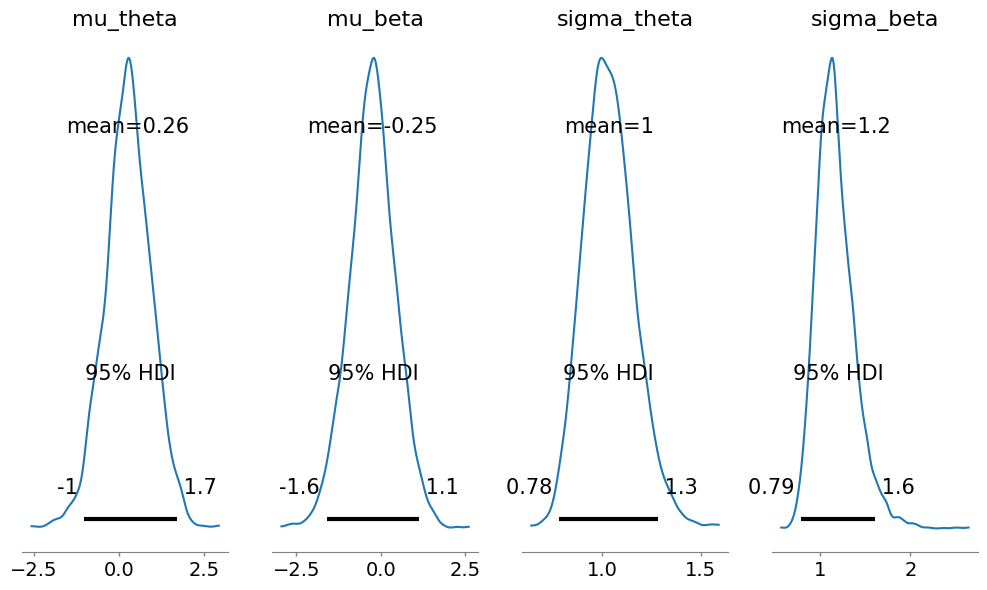

In [19]:
# Variables que queremos graficar
vars_to_plot = ["mu_theta", "mu_beta", "sigma_theta", "sigma_beta"]

az.plot_posterior(
    idata,
    var_names=vars_to_plot,
    figsize=(10, 6),
    hdi_prob=0.95
)

plt.tight_layout()
plt.show()


Se ve que el perfil de la habilidad de los usuarios parece ser mejor en promedio que el promedio de las tareas, por lo que se espera que, al menos en promedio, un usuario seleccionado al azar pueda terminar una tarea selecionada al azar. La varianza de los usuarios es menor que la de las tareas y la de las tareas presenta una mayor dispersion.

(g) Utilizar los valores muestreados para aproximar la probabilidad predictiva de que el usuario i−´esimo
resuelva la tarea j−´esima sobre los datos faltantes (debe indicar un resultado por cadena). Indicar la
probabilidad de que el usuario 4 resuleva la tarea 12. c: Para calcular probabilidades y esperanzas
predictivas no es necesario (ni recomendable) muestrear la distribuci´on predictiva. Basta con las muestras
de la distribuci´on a posteriori.

##**Planteo de como resolverlo**
No se tiene que muestrear la predictiva porque nuestra predictiva es una bernoulli, que tiene que decir si un usuario va a realizar una tarea o no univocamente. Como estoy en un problema bayesiano, se quiere saber cual es la probabilidad promedio de que el usuario apruebe esa tarea, basandose en las muestras que se recolectaron.


Como busco una probabilidad, busco asignarle promedios funcion de los datos que si tenemos para los usuarios en cuestion y la dificultad global de ese examen, ambos con distribucion conocida. Para cada una de las muestras, calculo la resta para todos los usuarios contra todas las tareas. Despues a esa diferncia se le calcula la probabilidad y despues se promedia entre las diferentes cadenas simuladas.

In [20]:
# model/idata: idata = resultado de pm.sample() con posterior de "theta" y "beta"
theta_arr = idata.posterior["theta"].values   # shape (n_chains, n_draws, n_users)
beta_arr  = idata.posterior["beta"].values    # shape (n_chains, n_draws, n_items)

n_chains, n_draws, n_users = theta_arr.shape
_, _, n_items = beta_arr.shape

# reconstruir la matriz de datos si no existe
#data = df_numeric.values.astype(float)
#mask = ~np.isnan(data)   # True where observed; False where missing

# indices de posiciones faltantes
missing_idx = np.argwhere(~mask)

# estructura para guardar probabilidades predictivas por cadena para cada (i,j) faltante
# dict clave = (i,j) -> array de length n_chains con P(resuelve | chain)
pp_missing = {}

# para cada cadena, calculamos la probabilidad (promedio sobre draws dentro de la cadena)
for chain in range(n_chains):
    # theta_chain: shape (n_draws, n_users)
    theta_chain = theta_arr[chain]   # (n_draws, n_users)
    beta_chain  = beta_arr[chain]    # (n_draws, n_items)
    diffs = theta_chain[:, :, None] - beta_chain[:, None, :]#Calculo la diferencia broadcasteando
    probs = sigmoid(diffs)  #le saco la probabiblidad
    #Promedio sobre los draws
    prob_est_chain = probs.mean(axis=0)
    # guardar para cada faltante
    for (i, j) in missing_idx:
        if (i, j) not in pp_missing:
            pp_missing[(i, j)] = np.empty(n_chains, dtype=float)
        pp_missing[(i, j)][chain] = prob_est_chain[i, j]

# Ahora pp_missing[(i,j)] es un array con la probabilidad según cada cadena (promedio dentro de la cadena)
#Tambien puedo calcular la media sober las cadenas.
pp_missing_mean = {k: v.mean() for k, v in pp_missing.items()}

# Esto me lo pidieron por consigna,la probabilidad de que usuario 4 resuelva tarea 12
user_index = 4
task_index = 12

key = (user_index, task_index)
if key in pp_missing:
    per_chain_probs = pp_missing[key]           # array length = n_chains
    mean_over_chains = float(per_chain_probs.mean())
    print(f"Probabilidades predictivas (por cadena) para usuario {user_index}, tarea {task_index}:")
    for c, p in enumerate(per_chain_probs):
        print(f"  cadena {c}:  P = {p:.4f}")
    print(f"Media sobre cadenas: P = {mean_over_chains:.4f}")
else:
    print(f"La posición (usuario {user_index}, tarea {task_index}) NO está marcada como faltante (no fue imputada).")


Probabilidades predictivas (por cadena) para usuario 4, tarea 12:
  cadena 0:  P = 0.8693
  cadena 1:  P = 0.8719
  cadena 2:  P = 0.8701
Media sobre cadenas: P = 0.8704
